In [1]:
import scipy.io
import os
import requests
import numpy as np
import time

# load the dataset from the online source
url='https://www.dropbox.com/s/875u1rkva9iffpj/Gist512CIFAR10.mat?dl=1'
response = requests.get(url)
with open(os.path.join("./", "Gist512CIFAR10.mat"), 'wb') as f:
    f.write(response.content)

mat = scipy.io.loadmat('./Gist512CIFAR10.mat')

from sklearn.preprocessing import Normalizer
data = mat['X']
data = Normalizer(norm='l2').fit_transform(data)
data= data- data.mean(axis=0)
classes = mat['X_class']

from sklearn.model_selection import train_test_split

np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(data, classes[0,:], test_size=0.05, random_state=42)
data_database, data_train, labels_database, labels_train = train_test_split(X_train, y_train[:], test_size=0.02, random_state=42)

In [44]:
# Importing libraries
import pandas as pd
from scipy.stats import mode

# K Nearest Neighbors Classification
class K_Nearest_Neighbors_Classifier() :
	def __init__(self, K) :
		self.K = K
		
	# Function to store training set
	def fit(self, X_train, Y_train) :
		self.X_train = X_train
		self.Y_train = Y_train
		# no_of_training_examples, no_of_features
		self.m, self.n = X_train.shape
	
	# Function for prediction
	def predict( self, X_test ) :
		self.X_test = X_test
		# no_of_test_examples, no_of_features
		self.m_test, self.n = X_test.shape
		# initialize Y_predict
		Y_predict = np.zeros( self.m_test )
	
		for i in range( self.m_test ) :
			x = self.X_test[i]
			# find the K nearest neighbors from current test example
			neighbors = np.zeros( self.K )
			neighbors = self.find_neighbors( x )
			# most frequent class in K neighbors
			Y_predict[i] = mode( neighbors )[0][0]	
			
		return Y_predict
	
	# Function to find the K nearest neighbors to current test example
	def find_neighbors( self, x ) :
		# calculate all the euclidean distances between current
		# test example x and training set X_train
		euclidean_distances = np.zeros( self.m )
		for i in range( self.m ) :
			d = self.euclidean( x, self.X_train[i] )
			euclidean_distances[i] = d
		# sort Y_train according to euclidean_distance_array and
		# store into Y_train_sorted
		inds = euclidean_distances.argsort()
		Y_train_sorted = self.Y_train[inds]
		return Y_train_sorted[:self.K]
	
	# Function to calculate euclidean distance
	def euclidean( self, x, x_train ) :
		return np.sqrt( np.sum( np.square( x - x_train ) ) )

# Driver code
def knn(K):
	# Model training
	model = K_Nearest_Neighbors_Classifier(K)
	model.fit(X_train, y_train)
	# Prediction on test set
	y_pred = model.predict(X_test)
	# measure performance
	correctly_classified = 0
	# counter
	count = 0

	for i in range( np.size( y_pred ) ) :
		if y_test[i] == y_pred[i] :
			correctly_classified = correctly_classified + 1
		count = count + 1
		
	print("Mean accuracy on test set by the naive knn classifier K={}: ".format(K), (correctly_classified/count))
	return (correctly_classified/count)

In [45]:
knn(3)

Mean accuracy on test set by the naive knn classifier K=3:  0.49166666666666664


0.49166666666666664

In [46]:
from collections import defaultdict
from sklearn.svm import SVC
from itertools import combinations
from sklearn.metrics.pairwise import pairwise_distances

def grh(K):

    n_vectors = 16
    dim = 512

    np.random.seed(0)
    random_vectors = np.random.randn(dim, n_vectors)

    # https://wiki.python.org/moin/BitwiseOperators
    # x << y is the same as multiplying x by 2 ** y
    powers_of_two = 1 << np.arange(n_vectors - 1, -1, step=-1)

    # we can do it for the entire corpus
    bin_indices_bits = data.dot(random_vectors) >= 0
    bin_indices = bin_indices_bits.dot(powers_of_two)
    bin_indices.shape

    table = defaultdict(list)
    for idx, bin_index in enumerate(bin_indices):
        table[bin_index].append(idx)

    svclassifier = SVC(kernel='linear') 

    adjacency_matrix=np.equal.outer(labels_train, labels_train).astype(float)
    row_sums = adjacency_matrix.sum(axis=1)
    adjacency_matrix = adjacency_matrix / row_sums[:, np.newaxis]

    n_iter=2

    for i in range(0,n_iter):

        bin_indices_bits = (data_train.dot(random_vectors) >= 0).astype(int)
        bin_indices_bits[bin_indices_bits==0]=-1
        bin_indices_bits_refined=np.matmul(adjacency_matrix,bin_indices_bits.astype(float))

        bin_indices_bits_refined=(bin_indices_bits_refined >=0).astype(int)
        bin_indices_bits_refined[bin_indices_bits_refined<=0]=-1

        bin_indices_bits = (0.25*bin_indices_bits_refined.astype(float) + 0.75*bin_indices_bits.astype(float))
        bin_indices_bits=(bin_indices_bits >=0).astype(int)
        bin_indices_bits[bin_indices_bits<=0]=-1

        grh_hyperplanes = random_vectors.copy()
        for j in range(0,n_vectors):
            if abs(sum(bin_indices_bits[:,j]))==data_train.shape[0]:
                # In case all bits are the same we generate a new random vector
                random_vector = np.random.randn(dim, 1)
                grh_hyperplanes[:,j]=random_vector[:,0]
            else:
                hyperplane=svclassifier.fit(data_train, bin_indices_bits[:,j]).coef_
                hyperplane=np.array(hyperplane)
                grh_hyperplanes[:,j]=hyperplane

        random_vectors = grh_hyperplanes.copy()

    # we can do it for the entire corpus
    bin_indices_bits = data_database.dot(random_vectors) >= 0
    # print(bin_indices_bits.shape)
    bin_indices = bin_indices_bits.dot(powers_of_two)
    bin_indices.shape


    table = defaultdict(list)
    for idx, bin_index in enumerate(bin_indices):
        table[bin_index].append(idx)

    precision_hist = []
    search_radius = 2

    for query_image, query_label in zip(X_test,y_test):

        bin_index_bits = np.ravel(query_image.dot(random_vectors) >= 0)
        candidate_set = set()

        
        n_vectors = bin_index_bits.shape[0]
        for different_bits in combinations(range(n_vectors), search_radius):
            index = list(different_bits)
            alternate_bits = bin_index_bits.copy()
            alternate_bits[index] = np.logical_not(alternate_bits[index])
            nearby_bin = alternate_bits.dot(powers_of_two)

            if nearby_bin in table:
                candidate_set.update(table[nearby_bin])

        # sort candidates by their true distances from the query
        candidate_list = list(candidate_set)

        if candidate_list:
            candidates = data_database[candidate_list[:]]
            ground_truth = labels_database[candidate_list[:]]
            distance = pairwise_distances(candidates, query_image.reshape(1,-1), metric='cosine').flatten()
            distance_col = 'distance'
            nearest_neighbors = pd.DataFrame({'id': candidate_list, 'class': ground_truth, distance_col: distance}).sort_values(distance_col).reset_index(drop=True)
            candidate_set_labels = nearest_neighbors.sort_values(by=['distance'], ascending=True)['class'][:K]
            precision = list(candidate_set_labels).count(query_label) / K
            # precision_history[search_radius].append(precision)
            precision_hist.append(precision)

    print("Mean accuracy on test set by the GRH classifier K={}: ".format(K), np.mean(precision_hist))
    return np.mean(precision_hist)



In [47]:
grh(3)

Mean accuracy on test set by the GRH classifier K=3:  0.4194444444444444


0.4194444444444444

In [50]:
knn_accuracy = []
knn_time = []
grh_accuracy = []
grh_time = []
for i in range(1,11):
    a = time.time()
    knn_accuracy.append(knn(i))
    b = time.time()
    knn_time.append(b-a)
    a = time.time()
    grh_accuracy.append(grh(i))
    b = time.time()
    grh_time.append(b-a)

Mean accuracy on test set by the naive knn classifier K=1:  0.4666666666666667
Mean accuracy on test set by the GRH classifier K=1:  0.43333333333333335
Mean accuracy on test set by the naive knn classifier K=2:  0.49166666666666664
Mean accuracy on test set by the GRH classifier K=2:  0.44583333333333336
Mean accuracy on test set by the naive knn classifier K=3:  0.49166666666666664
Mean accuracy on test set by the GRH classifier K=3:  0.4194444444444444
Mean accuracy on test set by the naive knn classifier K=4:  0.5166666666666667
Mean accuracy on test set by the GRH classifier K=4:  0.3958333333333333
Mean accuracy on test set by the naive knn classifier K=5:  0.5166666666666667
Mean accuracy on test set by the GRH classifier K=5:  0.37833333333333335
Mean accuracy on test set by the naive knn classifier K=6:  0.5583333333333333
Mean accuracy on test set by the GRH classifier K=6:  0.3805555555555556
Mean accuracy on test set by the naive knn classifier K=7:  0.525
Mean accuracy on 

In [79]:
import matplotlib.pyplot as plt
print("Average time for classifying 3000 test dataset images by the naive KNN model: {} seconds".format(round(np.mean(knn_time), 2)))
print("Average time for classifying 3000 test dataset images by the GRH model: {} seconds".format(round(np.mean(grh_time),2)))
print("Average accuracy for classifying 3000 test dataset images by the naive KNN model: {} percent".format(round(np.mean(knn_accuracy)*100, 2)))
print("Average accuracy for classifying 3000 test dataset images by the GRH model: {} percent".format(round(np.mean(grh_accuracy)*100,2)))

Average time for classifying 3000 test dataset images by the naive KNN model: 47.1 seconds
Average time for classifying 3000 test dataset images by the GRH model: 4.16 seconds
Average accuracy for classifying 3000 test dataset images by the naive KNN model: 51.58 percent
Average accuracy for classifying 3000 test dataset images by the GRH model: 39.17 percent


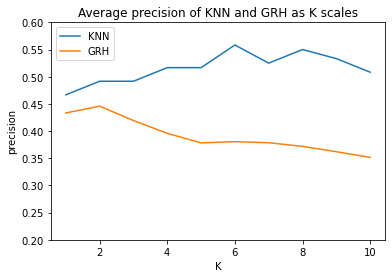

In [80]:
y = [i for i in range(1,11)]
plt.plot(y, knn_accuracy, label="KNN")
plt.plot(y, grh_accuracy, label="GRH")
plt.legend()
plt.title("Average precision of KNN and GRH as K scales")
plt.ylim([0.2, 0.6])
plt.xlabel("K")
plt.ylabel("precision")
plt.show()


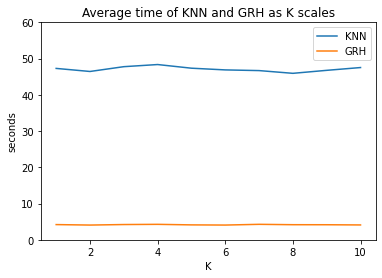

In [81]:
y = [i for i in range(1,11)]
plt.plot(y, knn_time, label="KNN")
plt.plot(y, grh_time, label="GRH")
plt.legend()
plt.title("Average time of KNN and GRH as K scales")
plt.ylim([0, 60])
plt.xlabel("K")
plt.ylabel("seconds")
plt.show()